# M2177.003100 Deep Learning <br> Assignment #3 Part 2: Image Captioning with RNNs

Copyright (C) Data Science Laboratory, Seoul National University. This material is for educational uses only. Some contents are based on the material provided by other paper/book authors and may be copyrighted by them. Written by Sunyoung Kwon, September 2017

Now, you're going to leave behind your implementations and instead migrate to one of popular deep learning frameworks, **TensorFlow**. <br>
In this notebook, <font color=red>**you should use tensorflow RNN libraries**</font> for image captioning of the Microsoft COCO dataset. <br>

For this exercise we will use the 2014 release of the **[Microsoft COCO dataset](http://mscoco.org/)** which has become the standard testbed for image captioning. The dataset consists of about 80,000 images, each annotated with 5 captions written by workers on Amazon Mechanical Turk.

The raw images takes up so much (nearly 20GB), we will use the preprocessed COCO datasets which are extracted features from the VGG-16 network and reduced the dimensionality of the features from 4096 to 512 by standford CS231N lecture.

To download the data, change to the `coco/` directory and run the script `get_coco_data.sh`.
- caption and image index: `train2014_captions.h5`
- idx_to_word, word_to_idx: `coco2014_vocab.json`
- extracted and reduced image features: `train2014_vgg16_fc7_pca.h5`
- URLs of the images for visualization: `train2014_urls.txt`
  <br>(Since images are downloaded on-the-fly, **you must be connected to the internet to view images**)

The file `coco_utils.py` has utilities for coco datasets from load COCO data to visualization and evaluation.

**Note**: certain details are missing or ambiguous on purpose, in order to test your knowledge on the related materials. However, if you really feel that something essential is missing and cannot proceed to the next step, then contact the teaching staff with clear description of your problem.

### Submitting your work:
<font color=red>**DO NOT clear the final outputs**</font> so that TAs can grade both your code and results.  
Once you have done **all Assignment Part 1, 2 & 3**, run the *CollectSubmission.sh* script with your **Team number** as input argument. <br>
This will produce a zipped file called *[Your team number].zip*. Please submit this file on ETL. &nbsp;&nbsp; (Usage: ./*CollectSubmission.sh* team_#)

### Some helpful tutorials and references for assignment #3:
- [1] TensorFlow official tutorials. [[link]](https://www.tensorflow.org/get_started/get_started)
- [2] Stanford CS231n lectures. [[link]](http://cs231n.stanford.edu/)
- [3] Microsoft COCO (http://mscoco.org/dataset/#overview)
- [4] Microsoft COCO Captions (https://arxiv.org/pdf/1504.00325.pdf)
- [5] Vinyals, Oriol, et al. "Show and tell: Lessons learned from the 2015 mscoco image captioning challenge." IEEE transactions on pattern analysis and machine intelligence 39.4 (2017): 652-663.



## Image Captioning (40 points)

- input : extracted image features from the VGG-16 network<br>
- output: predicted captions<br>
- evaluation: average BLEU scores for validation and independent test dataset
- data: download by run the `./coco/get_coco_data.sh`
- model: save your captiong model in model_path (`./models_captioning`)
- You muse use TensorFlow RNN module (such as tf.contrib.rnn)

Example of image captioning 

<img src="./files/showandtell.png" width=70%>
[Source: "Show and Tell: Lessons learned from the 2015 MSCOCO Image Captioning Challenge."]

## Load libraries
The preprocessed COCO datasets and libraries are loaded.<br>

In [24]:
import tensorflow as tf
import time, os, json
import numpy as np
import matplotlib.pyplot as plt

#import pandas as pd

import tensorflow.python.platform

from coco_utils import *
from captioning import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

model_path='./models_captioning'
data_path ='./coco/coco_captioning'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2


In [25]:
# Load COCO data from disk; this returns a dictionary
# We'll work with dimensionality-reduced features for this notebook
    
data = load_coco_data(base_dir=data_path)
if len(data)==8 : 
    print('COCO data load complete')
   
for k, v in data.items():
    if type(v) == np.ndarray:
        print(k, type(v), v.shape, v.dtype)
    else:
        print(k, type(v), len(v))

COCO data load complete
train_captions <class 'numpy.ndarray'> (400135, 17) int32
train_image_idxs <class 'numpy.ndarray'> (400135,) int32
features <class 'numpy.ndarray'> (82783, 512) float32
idx_to_word <class 'list'> 1004
word_to_idx <class 'dict'> 1004
urls <class 'numpy.ndarray'> (82783,) <U63
val_captions <class 'numpy.ndarray'> (10000, 17) int32
val_image_idxs <class 'numpy.ndarray'> (10000,) int32


### Descriptions for data
- data['train_captions'] : 400135장의 중복사진에 대한 캡션(최대 17글자로 각 글자는 1024개 단어 사전 중 하나)
- data['train_image_idxs'] : 400135장의 중복사진은 82783 종류로 분류되며 각 사진이 어떤 종류인지 0~82782의 idx로 대응
- data['features'] : 82783 종류에 대해 VGG-16 network를 통해 얻은 feature로 크기는 512

In [4]:
print(data['train_captions'][0])

[  1   4 142 510  10 667 415 277  58   2   0   0   0   0   0   0   0]


In [5]:
# Sample images and captions
captions, features, urls = sample_coco_minibatch(data, batch_size=1)
show_samples(captions, urls, data)

PermissionError: [WinError 32] 다른 프로세스가 파일을 사용 중이기 때문에 프로세스가 액세스 할 수 없습니다: 'C:\\Users\\Owner\\AppData\\Local\\Temp\\tmpimejvxvo'

## Data for training

For simple test, you can load subsample of total train data.<br>
But you should use <font color=red>**full train_data**</font> for final test.<br>
You will be able to verify your captioning model more quickly with the small train data.<br>
<font color=red>**You must show loss changes with full train data**</font> when you train. <br>
And you must show maxlen, n_words, captions.shape.


In [26]:
#-------------------------------------------------------------------------
# CAUTION: Do not change maxlen(17), n_words(1004), input_dimension(512)
# you should use 512 extracted image features
# Do not change coco_utils.py
#-------------------------------------------------------------------------

#----------------------------------------------
# [case 1] subsample
# Try to subsamples of train_data for simple test
#----------------------------------------------
train_data = load_coco_data(base_dir=data_path, max_train=500)

#----------------------------------------------
# [case 2] full train data
# Try to full train_data for real test
#----------------------------------------------
#train_data = data

captions = train_data['train_captions']
img_idx  = train_data['train_image_idxs']
img_features = train_data['features'][img_idx] # match imgs - features / shape (400135, 512)
word_to_idx = train_data['word_to_idx']
idx_to_word = train_data['idx_to_word']

n_words = len(word_to_idx)
maxlen = train_data['train_captions'].shape[1]
input_dimension = train_data['features'].shape[1]


print(n_words)
print(maxlen)
print(img_features.shape, captions.shape)

vcaptions = train_data['val_captions']
vimg_idx  = train_data['val_image_idxs']
vimg_features = train_data['features'][vimg_idx]
print(vimg_features.shape, vcaptions.shape)


1004
17
(500, 512) (500, 17)
(10000, 512) (10000, 17)


In [13]:
#test
#print(idx_to_word[data['train_captions'][0]])
print([idx_to_word[i] for i in captions[1]])

['<START>', 'a', 'zebra', 'standing', 'in', 'a', 'green', 'grass', 'covered', 'field', 'next', 'to', 'trees', '<END>', '<NULL>', '<NULL>', '<NULL>']


In [86]:
#################################################################################
# TODO: Implement for caption training class in captioning.py
# you should use TensorFlow RNN libraries (such as tf.contrib.rnn)
# You can modify classes, functions, parameters according to your model structure.
# You can also hide the train function in the Captioning class.
# Just show the loss changes depending on the learning procedure.
#
# class Captioning():
#     def __init(self,...):
#     def model(self,...):
#     def predict(self,...):
#################################################################################
"""
def train(img_features, captions):
    #-------------------------------------------------------------
    # You must show maxlen, n_words, caption.shape !!
    #-------------------------------------------------------------
    print(maxlen, n_words, captions.shape)
    #################################################
    # TODO: Implement caption training
    # - save your trained model in model_path
    # - must print about 10 loss changes !!
    #################################################

    
    #print("Current Cost: ", loss_value, "\t Epoch {}/{}".format(epoch, n_epochs))
    
    #################################################
    #                END OF YOUR CODE               #
    #################################################
    
train(img_features, captions) 
"""

from captioning import *
model = Captioning(batch_size =1)



[autoreload of captioning failed: Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\extensions\autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\extensions\autoreload.py", line 368, in superreload
    module = reload(module)
  File "C:\ProgramData\Anaconda3\lib\imp.py", line 315, in reload
    return importlib.reload(module)
  File "C:\ProgramData\Anaconda3\lib\importlib\__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 674, in exec_module
  File "<frozen importlib._bootstrap_external>", line 781, in get_code
  File "<frozen importlib._bootstrap_external>", line 741, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "C:\과제\Assignment3.tar\captioning.py", line 44
    @lazy_

In [83]:
tf.reset_default_graph()

hidden_size = 512
timesteps = 17
n_words = 1004
batch_size = 100

h0 = tf.placeholder(tf.float32, shape = [batch_size, hidden_size])
labels = tf.placeholder(tf.float32, [batch_size, timesteps, n_words])



lstm = tf.contrib.rnn.LSTMBlockCell(hidden_size)

#we should add [0,0...,0] to first input
x0 = tf.zeros([batch_size, 1, n_words])
_input = tf.concat([x0,labels[:,:timesteps-1,:]], axis = 1)
#_input = labels
state = lstm.zero_state(batch_size, tf.float32)
"""
state = [h0]
for i in range(timesteps-1):
    state.append(tf.Variable(tf.zeros([batch_size, hidden_size])))
    
state = tuple(state)
"""

c_init = np.zeros((batch_size, lstm.state_size.c), np.float32)
#h_init = np.zeros((batch_size, lstm.state_size.h), np.float32)
h_init = h0

state_init = [c_init, h_init]

"""
c_in = tf.placeholder(tf.float32, 
            shape=[batch_size, lstm.state_size.c],
            name='c_in')
h_in = tf.placeholder(tf.float32, 
            shape=[batch_size, lstm.state_size.h],
            name='h_in')
state_in = [c_in, h_in]
"""
state_in = rnn.LSTMStateTuple(c_init, h_init)
#_input = tf.unstack(labels, timesteps, axis=1)
#print(_input[0])

#outputs = []
#for t in range(timesteps):
hidden_output, _= tf.nn.dynamic_rnn(lstm, _input, initial_state = state_in, time_major = False, dtype = tf.float32)
    #outputs.append(output)
    
Wy = tf.Variable(tf.truncated_normal([hidden_size, n_words])) # hidden state : (batch_size, hidden_len=512) / y : (batch_size, n_word = 1004)
by = tf.Variable(tf.zeros([n_words]), dtype = tf.float32)    

hidden_output = tf.unstack(hidden_output, timesteps, axis = 1)
labels_us = tf.unstack(labels, timesteps, axis=1)

losses = 0
accuracy = 0
outputs = []
for i in range(timesteps):
    output = tf.matmul(hidden_output[i], Wy) + by
    output = tf.nn.tanh(output)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = output, labels = labels_us[i]))
    losses += loss
    outputs.append(output)
    #accuracy += tf.reduce_sum(tf.math.equal(tf.argmax(output,axis=1), tf.argmax(labels_us[i], axis = 1)))
losses /= timesteps
accuracy /= timesteps

optimize = tf.train.AdamOptimizer(learning_rate = 0.001).minimize(losses)




#captions : (5,17) -> (5, 17, 1004)
cap =  (np.arange(n_words) == captions[:,:,None]).astype(np.float32)

num_iterations = 10
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    permutation = np.random.permutation(img_features.shape[0])
    shuffled_h0 = img_features[permutation,:]
    shuffled_captions = cap[permutation,:]
    for iter in range(num_iterations):
        offset = iter * batch_size % (img_features.shape[0] - batch_size)
        batch_h0 = shuffled_h0[offset:offset+batch_size]
        batch_captions =  shuffled_captions[offset:offset+batch_size]
        feeds = {h0 : batch_h0, labels : batch_captions}
                
        sess.run(optimize, feed_dict = feeds)
        loss = sess.run(losses, feed_dict = feeds)
        
        out, lab = sess.run([outputs, labels_us], feed_dict = feeds)
        acc = 0
        for i in range(timesteps):
            acc += np.sum(np.equal(np.argmax(out[i],axis=1), np.argmax(lab[i],axis=1))) / batch_size
        acc /= timesteps
        print("iter: %d   loss : %.3f   accuracy : %.3f" % (iter, loss, acc * 100))
    




iter: 0   loss : 6.570   accuracy : 22.289
iter: 1   loss : 6.378   accuracy : 30.607
iter: 2   loss : 6.271   accuracy : 31.388
iter: 3   loss : 6.209   accuracy : 32.583
iter: 4   loss : 6.161   accuracy : 33.594
iter: 5   loss : 6.119   accuracy : 34.651
iter: 6   loss : 6.079   accuracy : 35.892
iter: 7   loss : 6.041   accuracy : 36.581
iter: 8   loss : 6.002   accuracy : 37.224
iter: 9   loss : 5.962   accuracy : 37.178


In [37]:
tf.reset_default_graph()
from captioning import *

hidden_size = 512
timesteps = 17
n_words = 1004
batch_size = 128
LSTM_model = Captioning(batch_size = batch_size)

#captions : (5,17) -> (5, 17, 1004)
cap =  (np.arange(n_words) == captions[:,:,None]).astype(np.float32)

num_iterations = 10
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    permutation = np.random.permutation(img_features.shape[0])
    shuffled_h0 = img_features[permutation,:]
    shuffled_captions = cap[permutation,:]
    for step in range(num_iterations):
        offset = step * batch_size % (img_features.shape[0] - batch_size)
        batch_h0 = shuffled_h0[offset:offset+batch_size]
        batch_captions =  shuffled_captions[offset:offset+batch_size]
        feeds = {LSTM_model.h0 : batch_h0, LSTM_model.labels : batch_captions}
                
        sess.run(LSTM_model.train, feed_dict = feeds)
        loss = sess.run(LSTM_model.loss, feed_dict = feeds)
        
        out, lab = sess.run([LSTM_model.outputs, LSTM_model.labels_unstack], feed_dict = feeds)
        acc = 0
        for i in range(timesteps):
            acc += np.sum(np.equal(np.argmax(out[i],axis=1), np.argmax(lab[i],axis=1))) / batch_size
        acc /= timesteps
        print("iter: %d\n    train loss : %.3f   train accuracy : %.3f" % (iter, loss, acc * 100))
        print("    valid loss : %.3f    valid accuracy : %.3f" % )

iter: 0   loss : 6.593   accuracy : 17.325
iter: 1   loss : 6.555   accuracy : 27.895
iter: 2   loss : 6.528   accuracy : 28.447
iter: 3   loss : 6.303   accuracy : 33.732
iter: 4   loss : 6.323   accuracy : 32.767
iter: 5   loss : 6.316   accuracy : 31.388
iter: 6   loss : 6.187   accuracy : 38.465
iter: 7   loss : 6.187   accuracy : 36.811
iter: 8   loss : 6.192   accuracy : 33.824
iter: 9   loss : 6.092   accuracy : 34.697


### Run_Model

In [66]:
import math
import time
train_loss, train_acc, valid_loss, valid_acc = [], [], [], []
def run_model(session, model, X, Y, epochs=1, batch_size = 128, is_training=False):
    #for training
    iterations = math.ceil(Y.shape[0] // batch_size)
    if is_training:
        for epoch in range(epochs):
            # data randomization (shuffle)
            permutation = np.random.permutation(Y.shape[0])
            shuffled_dataset = X[permutation,:]
            shuffled_labels = Y[permutation,:]
            time_sum = 0
            n_time = 0
            for step in range(iterations):
                offset = step * batch_size % (Y.shape[0] - batch_size)
                batch_x = shuffled_dataset[offset:offset+batch_size]
                batch_y = shuffled_labels[offset:offset+batch_size]
                batch_y = captions_encoding(batch_y)
                
                feeds = {model.h0 : batch_x, model.labels : batch_y, model.keep_probs : 0.5}
                start_train = time.time()
                session.run(model.optimize, feed_dict = feeds)
                time_sum += (time.time() - start_train)
                n_time += 1
                
                if(step % 100 == 0):
                    start_loss = time.time()
                    #calculate loss
                    los = session.run(model.loss, feed_dict = feeds)
                    #calculate accuracy
                    acc = 0
                    out, lab = session.run([model.outputs, model.labels_unstack], feed_dict = feeds)
                    for i in range(timesteps):
                        acc += np.sum(np.equal(np.argmax(out[i],axis=1), np.argmax(lab[i],axis=1))) / batch_size
                    acc /= timesteps
                    #add to draw a performance curve
                    train_loss.append(los) # loss per batch_size
                    train_acc.append(acc * 100)
                    #print how much time has passed
                    print("epoch %d (iter %d/%d)\n   train_time: %.3f  loss_time: %.3f" 
                          % (epoch+1, step, iterations, time_sum/n_time, time.time() - start_loss))
                    time_sum = 0
                    n_time = 0
                    #print train acc / loss
                    print("   train accuracy %.2f%%  train loss %.3f" 
                          % (acc * 100, los))
                """
                t_valid = time.time()
                los, acc = run_model(session, model, X_val, Y_val)
                valid_loss.append(los)
                valid_acc.append(acc)
                print("   valid time: %.3f" % (time.time() - t_valid))
                print("   valid accuracy %.2f%%  valid loss %.3f" % (acc, los * batch_size))
                """
        print("Training done!")
    else:
        ls = 0
        acc = 0
        for step in range(iterations):
            offset = step * batch_size % (Y.shape[0] - batch_size)
            batch_x = X[offset:offset+batch_size]
            batch_y = Y[offset:offset+batch_size]
            batch_y = captions_encoding(batch_y)
            feeds = {model.h0 : batch_x, model.labels : batch_y, model.keep_probs : 0.5}
            #calculate loss
            l = session.run(model.loss, feed_dict = feeds)
            #calculate accuracy
            acc = 0
            out, lab = session.run([model.outputs, model.labels_unstack], feed_dict = feeds)
            for i in range(timesteps):
                acc += np.sum(np.equal(np.argmax(out[i],axis=1), np.argmax(lab[i],axis=1))) / batch_size
            acc /= timesteps            
            ls += l
        return (ls / X.shape[0], acc / X.shape[0] * 100)

### Train / Validation Data

In [63]:
Y_train = data['train_captions']
img_idx = data['train_image_idxs']
X_train = data['features'][img_idx]

Y_val = data['val_captions']
val_img_idx = data['val_image_idxs']
X_val = data['features'][val_img_idx]

print(X_train.shape, Y_train.shape)
print(X_val.shape, Y_val.shape)

#captions : (5,17) -> (5, 17, 1004)
def captions_encoding(captions) :
    return (np.arange(n_words) == captions[:,:,None]).astype(np.float32)

#Y_train_e = captions_encoding(Y_train)
#Y_val_e = captions_encoding(Y_val)

(400135, 512) (400135, 17)
(10000, 512) (10000, 17)


## Run LSTM Model1

In [67]:
# Clear old variables
time_base = time.time()
tf.reset_default_graph()    
from captioning import *

hidden_size = 512
timesteps = 17
n_words = 1004
batch_size = 128


# Declare out simple model
print("Model Construct Start")
start_model = time.time()
model = Captioning(batch_size = batch_size)
print("Model Construct Finished || time consumed : %.3f" % (time.time() - start_model))

# Hyperparamters
training_epochs = 2
    
conf = tf.ConfigProto()
conf.gpu_options.per_process_gpu_memory_fraction = 0.2
# Now, create a tf.Session and train the model
with tf.Session(config=conf) as sess:
    sess.run(tf.global_variables_initializer())
    print("Train Start")
    run_model(sess, model, X_train, Y_train, epochs = training_epochs, is_training=True)
    print("Train Finish")
    t_train = time.time()
    print("(Loss, Accuracy) on Training Dataset (%.4f, %.2f%%)" % run_model(sess, model, X_train, Y_train))
    print("Time for trainset loss/acc : %.3f" % (-t_train + time.time()))
    t_valid = time.time()
    print("(Loss, Accuracy) on Validataion Dataset (%.4f, %.2f%%)" % run_model(sess, model, X_val, Y_val))
    print("Time for validset loss/acc : %.3f" % (-t_valid + time.time()))
    print("Total Time : %.3f" % (time.time() - time_base))

Model Construct Start
Model Construct Finished || time consumed : 3.130
Train Start
epoch 1 (iter 0/3126)
   train_time: 2.264  loss_time: 1.285
   train accuracy 0.13%  train loss 6.606
epoch 1 (iter 100/3126)
   train_time: 1.417  loss_time: 1.018
   train accuracy 0.24%  train loss 5.581
epoch 1 (iter 200/3126)
   train_time: 1.409  loss_time: 1.017
   train accuracy 0.24%  train loss 5.445
epoch 1 (iter 300/3126)
   train_time: 1.592  loss_time: 1.044
   train accuracy 0.24%  train loss 5.365
epoch 1 (iter 400/3126)
   train_time: 1.409  loss_time: 0.996
   train accuracy 0.26%  train loss 5.324
epoch 1 (iter 500/3126)
   train_time: 1.414  loss_time: 1.014
   train accuracy 0.25%  train loss 5.343
epoch 1 (iter 600/3126)
   train_time: 1.421  loss_time: 1.004
   train accuracy 0.26%  train loss 5.301
epoch 1 (iter 700/3126)
   train_time: 1.407  loss_time: 1.022
   train accuracy 0.26%  train loss 5.268
epoch 1 (iter 800/3126)
   train_time: 1.415  loss_time: 1.004
   train accura

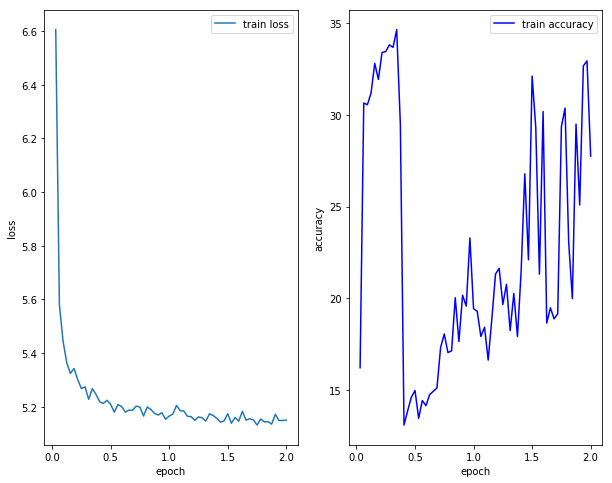

In [72]:
#### my_model2
import matplotlib.pyplot as plt

fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
fig.subplots_adjust(hspace = 2)

x = [ (i+1)/32 for i in range(64)]

#valid_loss2 = [ i*500 for i in valid_loss]
ax1.plot(x, train_loss, label = 'train loss')
#ax1.plot(x, valid_loss2, label = 'valid loss')
ax1.set_xlabel("epoch")
ax1.set_ylabel("loss")
ax1.legend()
#ax1.title("Losses over epochs")


ax2.plot(x, train_acc, c = 'blue', label = 'train accuracy')
ax2.set_xlabel("epoch")
ax2.set_ylabel("accuracy")

#ax2.plot(x, valid_acc, c = 'red', label = 'validation accuracy')
ax2.legend()

plt.show()

### [links for initial state]
- https://stackoverflow.com/questions/38441589/is-rnn-initial-state-reset-for-subsequent-mini-batches/41239965
- https://www.programcreek.com/python/example/102774/tensorflow.contrib.rnn.LSTMStateTuple
- https://github.com/tensorflow/tensorflow/issues/3476

### 전체적인 구조
- http://www.hanbit.co.kr/media/channel/view.html?cms_code=CMS6074576268
- [Introduction to Recurrent Networks in Tensorflow]('https://danijar.com/introduction-to-recurrent-networks-in-tensorflow/')
- <font color = 'red'>[RNN Tutorial Part 4 - GRU/LSTM RNN 구조를 Python과 Theano를 이용하여 구현하기]('https://aikorea.org/blog/rnn-tutorial-4/')</font>

In [75]:
a = tf.Variable([[[1,2,3],[4,5,6]]])
print(a)
a = tf.unstack(a, axis=1)
a = tf.stack(a, axis=1)
print(a)

<tf.Variable 'Variable_71:0' shape=(1, 2, 3) dtype=int32_ref>
Tensor("stack_7:0", shape=(1, 2, 3), dtype=int32)


## Evaluation

You can test your model in train, validation samples with sample images.<br>
Final evaluation will be done with average BLEU score.<br>
BLEU (bilingual evaluation understudy) score is between 0 and 1. The values closer to 1 represents more similar texts. <br>
https://en.wikipedia.org/wiki/BLEU
<font color=red>**Your model could be evaluated without traning procedure,**</font> if you saved and loaded your model properly.


In [ ]:
import tensorflow as tf
import time, os, json
import numpy as np
import matplotlib.pyplot as plt

#import pandas as pd

import tensorflow.python.platform

from coco_utils import *
from captioning import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

model_path='./models_captioning'
data_path ='./coco/coco_captioning'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

train_data = load_coco_data()

captions = train_data['train_captions']
img_idx  = train_data['train_image_idxs']
img_features = train_data['features'][img_idx]
word_to_idx = train_data['word_to_idx']
idx_to_word = train_data['idx_to_word']
vcaptions = train_data['val_captions']
vimg_idx  = train_data['val_image_idxs']
vimg_features = train_data['features'][vimg_idx]

n_words = len(word_to_idx)
maxlen = train_data['train_captions'].shape[1]


In [ ]:
# Write your code for image captioning predicting
# The image_captioning should include following functions
# - load your saved model 
# - return predicted captions from image features

def image_captioning(features) :
    pr_captions = np.zeros((features.shape[0],maxlen),int)
    #################################################
    # TODO: Implement predicting image captioning
    # - load your saved model
    # - predict the captions
    #################################################
    
    #################################################
    #                END OF YOUR CODE               #
    #################################################
    return pr_captions

In [ ]:
for split in ['train', 'val']:
    minibatch = sample_coco_minibatch(train_data, split=split, batch_size=1)

    gt_captions, features, urls = minibatch
    pr_captions = image_captioning(features)

    show_predict_samples(gt_captions, pr_captions, urls, train_data)

In [ ]:
# Prints unigram BLEU score averaged over val dataset

def evaluate_model(data, split):
    BLEUscores = {}

    minibatch = sample_coco_minibatch(data, split=split, batch_size="All")
    gt_captions, features, urls = minibatch
    gt_captions = decode_captions(gt_captions, data['idx_to_word'])

    pr_captions = image_captioning(features)
    pr_captions = decode_captions(pr_captions, data['idx_to_word'])

    total_score = 0.0
        
    for gt_caption, pr_caption, url in zip(gt_captions, pr_captions, urls):
        total_score += BLEU_score(gt_caption, pr_caption)

    BLEUscores[split] = total_score / len(pr_captions)

    for split in BLEUscores:
        print('Average BLEU score for %s: %f' % (split, BLEUscores[split]))


In [ ]:
evaluate_model(train_data,'val')

In [ ]:
# This cell is for TA, TA will evaluate your model with independent test_data
# the number of captions of test_data is about 200,000
# you should handle captions up to 200,000

#evaluate_model(test_data,'test')



## Describe what you did here
In this cell you should also write an explanation of what you did.<br>
(A detailed description of your model, structure, tensorflow module and others)
<font color=red>**You must describe your model**</font>

_Tell us here_